In [1]:
import gym
import gym_minigrid
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [3]:
_max_pixel_values = np.array([10, 5, 2])

def data_collection(env_name: str = 'MiniGrid-DoorKey-5x5-v0', num_episodes: int = 1000):
    env = gym.make(env_name)
    buffer_size = 1e3
    data = np.zeros((int(buffer_size), 7, 7, 3), dtype=np.float32)
    i = 0
    for _ in range(num_episodes):
        env.reset()
        done = False
        while not done:
            if i >= buffer_size:
                break
            action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            data[i] = obs['image'] / _max_pixel_values
            i += 1
    return data

In [4]:
# Make data into a torch dataset
class GridDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(GridDataset, self).__init__()
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    
# Define the model
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.enc1 = nn.Linear(7*7*3, 512)
        self.enc2 = nn.Linear(512, 64)
        self.dec1 = nn.Linear(64, 512)
        self.dec2 = nn.Linear(512, 7*7*3)
        
    def encode(self, x):
        x = F.elu(self.enc1(x))
        x = F.elu(self.enc2(x))
        return x
    
    def decode(self, x):
        x = F.elu(self.dec1(x))
        x = F.elu(self.dec2(x))
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [5]:
data = data_collection()
dataset = GridDataset(data)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch: 0 Loss: 0.01594374965876341
Epoch: 1 Loss: 0.0031012348625808956
Epoch: 2 Loss: 0.0013645517881959676
Epoch: 3 Loss: 0.0005925501033198088
Epoch: 4 Loss: 0.0002819240598473698
Epoch: 5 Loss: 0.00020523548737401144
Epoch: 6 Loss: 0.00016175547119928524
Epoch: 7 Loss: 0.00011143335010274313
Epoch: 8 Loss: 8.632825285894796e-05
Epoch: 9 Loss: 5.8519460260868074e-05
Epoch: 10 Loss: 3.1592248677043244e-05
Epoch: 11 Loss: 2.3544387411675416e-05
Epoch: 12 Loss: 2.1391262154793366e-05
Epoch: 13 Loss: 1.567836495814845e-05
Epoch: 14 Loss: 1.2075928338163067e-05
Epoch: 15 Loss: 9.408017896930688e-06
Epoch: 16 Loss: 9.787204216991085e-06
Epoch: 17 Loss: 6.7292015592101964e-06
Epoch: 18 Loss: 5.3563370383926664e-06
Epoch: 19 Loss: 5.119859033584362e-06
Epoch: 20 Loss: 4.7974974986573215e-06
Epoch: 21 Loss: 4.07357673975639e-06
Epoch: 22 Loss: 4.748879571707221e-06
Epoch: 23 Loss: 5.4967897922324486e-06
Epoch: 24 Loss: 6.983544320974034e-06
Epoch: 25 Loss: 5.9110279817105035e-06
Epoch: 26 Lo

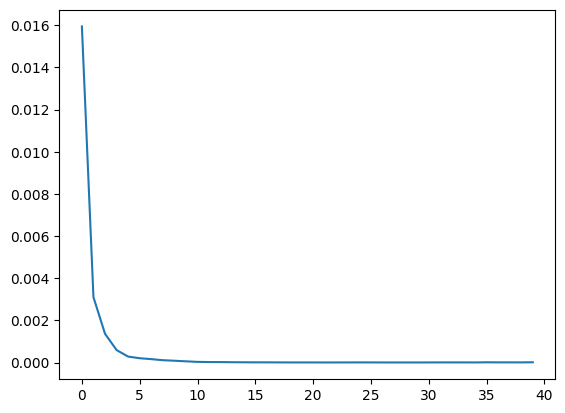

In [6]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


def train(model, loader, optimizer, criterion, epochs=40):
    losses = []
    for epoch in range(epochs):
        loss_total = 0.
        size = 0
        for i, data in enumerate(loader):
            data = data.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            loss_total += loss.item() * data.size(0)
            size += data.size(0)
        print(f'Epoch: {epoch} Loss: {loss_total / size}')
        losses.append(loss_total / size)
    return model, losses

    
model, losses = train(model, loader, optimizer, criterion)
plt.plot(losses)

In [7]:
_max_pixel_values = np.array([10, 5, 2])

env = gym.make('MiniGrid-DoorKey-5x5-v0')
env.reset()

def render_obs(obs):
    obs_render = obs.copy()
    if obs_render.dtype != np.uint8:
        for i, max_val in enumerate(_max_pixel_values):
            obs_render[..., i] *= max_val
            obs_render[..., i] = np.clip(obs_render[..., i], 0, max_val)
            obs_render = obs_render.astype(np.uint8)
    
    return env.get_obs_render(obs_render, tile_size=9)

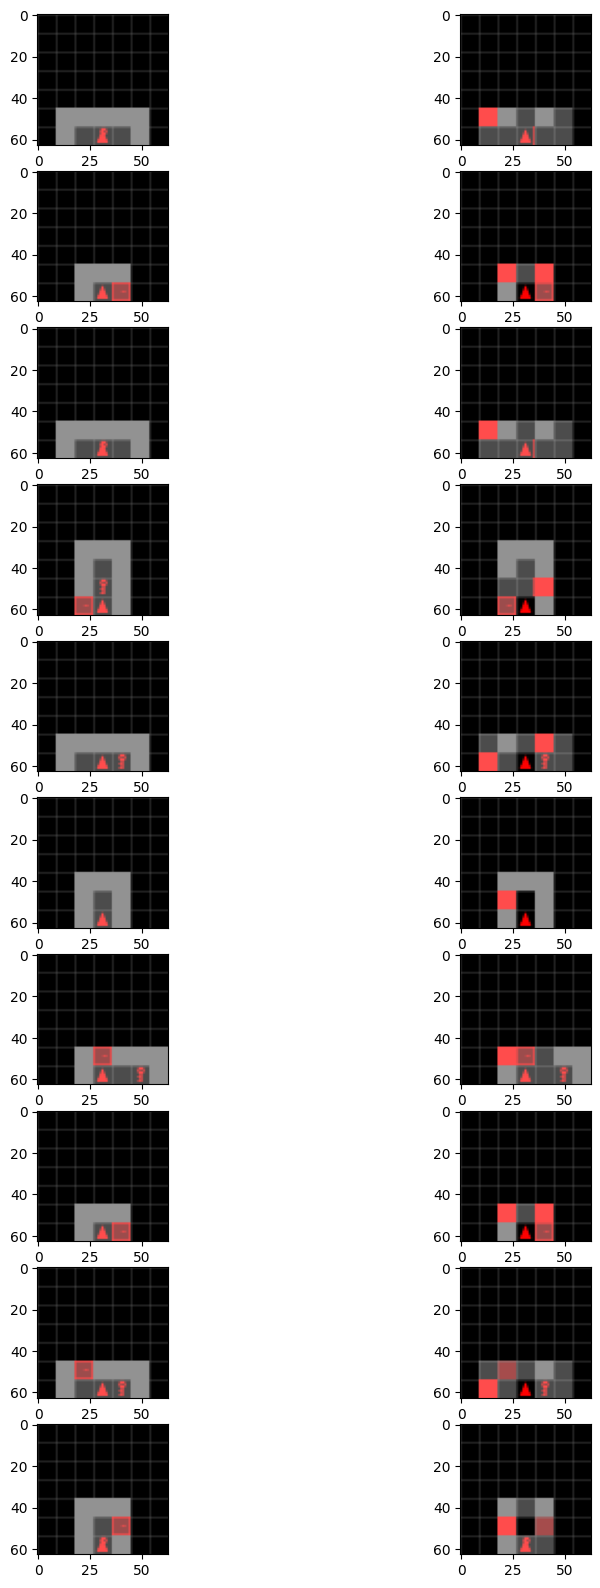

In [8]:
# Sample 10 observations from the dataset and decode them
# and plot both original render and decoded render
random_indices = np.random.randint(0, len(data), size=10)
random_obs = data[random_indices]
model.eval()
with torch.no_grad():
    random_obs_decoded = model(torch.tensor(random_obs).view(10, -1).to(device))

random_obs_decoded = random_obs_decoded.cpu().numpy().reshape(10, 7, 7, 3)

# plt.imshow(render_obs(data[0]))
fig, axes = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    axes[i, 0].imshow(render_obs(random_obs[i]))
    axes[i, 1].imshow(render_obs(random_obs_decoded[i]))
